# Analyze the SQL database

This notebook can be used to extract some information (number of spectra, precursor masses' distribution...) from a
SQL file generated with the MsBackendSqlite backend of the RformassSpectrometry package.

In [8]:
import sys
import os
import time
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

print(sys.executable)

/home/maesk/miniconda3/envs/falcon/bin/python


### Establish the connection to the DB

In [9]:
file = "/media/maesk/WD/MS/erwinia/erwinia.db"
figPath = "database" # Relative path where the figures should be saved
prefix = "erwinia_" # Prefix to include in the names of the figure images

conn = sqlite3.connect(file)
c = conn.cursor()

### Count the number of spectra for each level

In [10]:
start = time.time()

c.execute(f"SELECT msLevel, COUNT(_pkey) FROM msdata GROUP BY msLevel ORDER BY msLevel")
nSpectraMs = c.fetchall()
print("Time needed {0:.2f} seconds".format(time.time()-start)) # ~4983 seconds

levelsLabels = ["MS"+str(s[0]) for s in nSpectraMs]
levelsNSpectra = [s[1] for s in nSpectraMs]

for l, n in zip(levelsLabels, levelsNSpectra):
    print(l, ":", n, "spectra")
print("Total :", sum(levelsNSpectra), "spectra")

Time needed 0.04 seconds
MS2 : 6103 spectra
Total : 6103 spectra


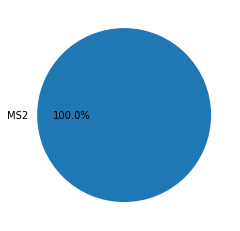

In [11]:
nLevels = len(levelsLabels)
fig, ax = plt.subplots()
explode = [0]*nLevels
explode[levelsLabels.index("MS2")]
ax.pie(levelsNSpectra, labels=levelsLabels, autopct='%1.1f%%', explode=explode)
fig.savefig(os.path.join(figPath, prefix+"msLevelsPieChart.png"), dpi=200, transparent=False)
plt.show()

### List the input files, and the corresponding _pkey ranges

In [12]:
# Only consider the MS2 spectra
c.execute(f"SELECT dataOrigin, MIN(_pkey), MAX(_pkey), COUNT(_pkey) FROM msdata WHERE msLevel = 2 GROUP BY dataOrigin")
fileRanges = c.fetchall()

In [13]:
totalMS2 = 0
f = open(os.path.join(figPath, prefix+"filesFractions.csv"), "w")
f.write("dataOrigin,minPKey,maxPKey,nMS2,total\n")
for dataOrigin, minPKey, maxPKey, nMS2 in fileRanges:
    totalMS2 = totalMS2 + nMS2
    f.write("{},{},{},{},{}\n".format(dataOrigin, minPKey, maxPKey, nMS2, totalMS2))
f.close()

### Verify the precursorMz distribution

Extract all the precursor mz values from the database

In [14]:
c.execute(f"SELECT precursorMz, precursorCharge FROM msdata ORDER BY precursorMz")
res = c.fetchall()

# Build a dictionary for each charge (which are in different buckets in falcon)
dic = {}
for r in res:
    if not r[1] in dic:
        dic[r[1]] = []
    # r[2] is the precursor charge, r[1] the m/z bin
    dic[r[1]].append(r[0])
plt.rcParams.update({'font.size': 15})

Plot the distribution of the precursor mz's for each charge

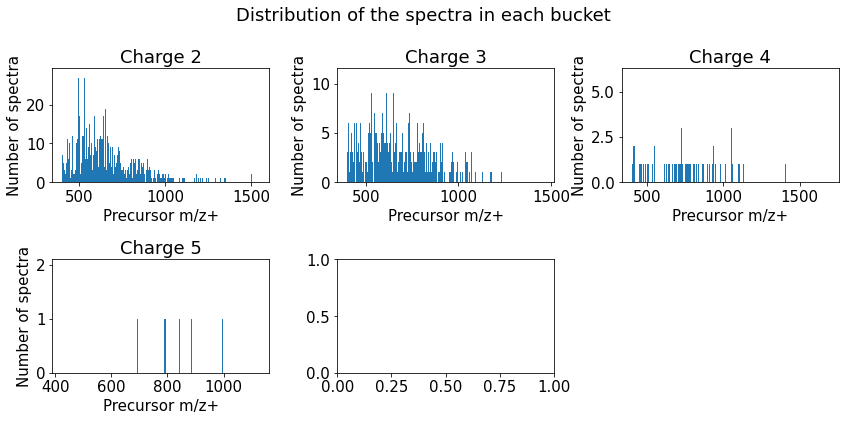

In [15]:
key_max = max(dic.keys(), key=(lambda k: dic[k]))
key_min = min(dic.keys(), key=(lambda k: dic[k]))
charges = range(key_min, key_max+1)

fig, axs = plt.subplots(2,3,figsize=(12,6))
fig.suptitle("Distribution of the spectra in each bucket")
for c in charges:
    ind = c-key_min
    min_mz = int(np.floor(min(dic[c])))
    max_mz = int(np.ceil(max(dic[c])))
    range_buckets = range(min_mz, max_mz+1)
    ax = axs[int(ind/3),ind%3]
    ax.hist(dic[c], range_buckets)
    ax.set(xlabel="Precursor m/z+", ylabel="Number of spectra")
    #ax.label_outer()
    ax.set_title(f"Charge {c}")
fig.delaxes(axs[1,2])
fig.tight_layout()
plt.savefig(os.path.join(figPath, prefix+"spectra_per_bucket.png"), dpi=300)
plt.show()

From the previous request, we can deduce the number of spectra for each charge

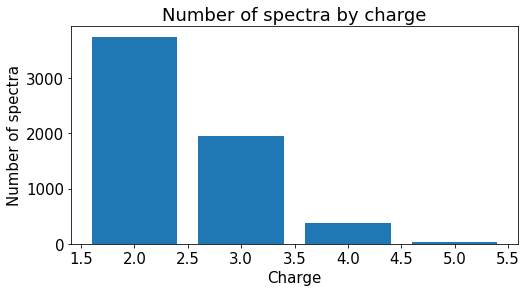

In [16]:
#Plot the number of spectra for each charge
nspectra = []
for c in charges:
    nspectra.append(len(dic[c]))

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(charges, nspectra)
ax.set_title("Number of spectra by charge")
ax.set(xlabel="Charge", ylabel="Number of spectra")
plt.savefig(os.path.join(figPath, prefix+"spectra_by_charge.png"), dpi=300, bbox_inches='tight')
plt.show()